# Basic EDA

In [3]:
import pandas as pd
import psycopg2 as pg
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import pandas.io.sql as pd_sql
sns.set()

In [4]:
#connecting to AWS Postgres
connection_args = {
    'host': '.........',  # You will need to put the PUBLIC IP address of your AWS instance here
    'user': 'ubuntu',    # your username on AWS 
    'dbname': 'insta2',    # DB that we are connecting to
    'port': 5432             # port we opened on AWS
}

connection = pg.connect(**connection_args)

In [5]:
#creating a df from merged1 file
query = "SELECT * FROM insta_sample;"
all=pd_sql.read_sql(query, connection)
print(all.shape)
all.head(3)

(1626615, 10)


,order_id,product_id,add_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour,days_last_order
0,8,23423,1,1,3107,prior,5,4,6,17.0
1,32,49683,7,1,119216,prior,4,1,19,11.0
2,32,12384,1,1,119216,prior,4,1,19,11.0


In [6]:
#creating a df from merged dep_pr_aisles file
query = "SELECT * FROM mer_dep_pr_aisles ;"
dept=pd_sql.read_sql(query, connection)
print(dept.shape)
dept.head(3)

(49688, 6)


,department_id,aisle_id,product_id,product_name,aisle,department
0,1,38,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,frozen meals,frozen
1,1,116,8,Cut Russet Potatoes Steam N' Mash,frozen produce,frozen
2,1,79,18,Pizza for One Suprema Frozen Pizza,frozen pizza,frozen


In [7]:
all.eval_set.value_counts()

prior    1559676
train      66939
Name: eval_set, dtype: int64

In [8]:
all.user_id[all.eval_set=='train'].unique().shape

(6350,)

In [9]:
all.user_id[all.eval_set=='prior'].unique().shape

(10000,)

In [10]:
order_products_train = all[all.eval_set == 'train']
order_products_prior = all[all.eval_set == 'prior']

In [11]:
train_ids = order_products_train['user_id'].unique() 
order_products_prior = order_products_prior[order_products_prior['user_id'].isin(train_ids)]

In [12]:
order_products_prior.shape

(989925, 10)

In [13]:
order_products_prior.sample(1)

,order_id,product_id,add_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour,days_last_order
423899,888746,32650,6,1,56617,prior,22,3,12,14.0


In [14]:
prior=pd.merge(order_products_prior, dept,on=['product_id'])
prior.sample(1)

,order_id,product_id,add_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour,days_last_order,department_id,aisle_id,product_name,aisle,department
101182,1485660,8518,8,1,161938,prior,8,5,13,30.0,4,83,Organic Red Onion,fresh vegetables,produce


In [15]:
prior.shape

(989925, 15)

In [16]:
prior.head()

,order_id,product_id,add_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour,days_last_order,department_id,aisle_id,product_name,aisle,department
0,8,23423,1,1,3107,prior,5,4,6,17.0,3,43,Original Hawaiian Sweet Rolls,buns rolls,bakery
1,35253,23423,2,1,13805,prior,10,6,15,8.0,3,43,Original Hawaiian Sweet Rolls,buns rolls,bakery
2,128276,23423,1,1,62020,prior,18,6,13,6.0,3,43,Original Hawaiian Sweet Rolls,buns rolls,bakery
3,177453,23423,2,1,198487,prior,3,2,9,0.0,3,43,Original Hawaiian Sweet Rolls,buns rolls,bakery
4,202072,23423,2,0,3107,prior,1,1,21,NaN,3,43,Original Hawaiian Sweet Rolls,buns rolls,bakery


In [17]:
# most ordered products
most_ordered = (prior.groupby('product_name')[['order_id']].count()
                                    .sort_values(('order_id'), ascending=False).reset_index().head(10))                          
most_ordered.columns=['product_name', 'number_of_orders']
most_ordered.sort_values(by='number_of_orders', inplace=True)


Text(0.5, 1.0, 'Most Ordered Products')

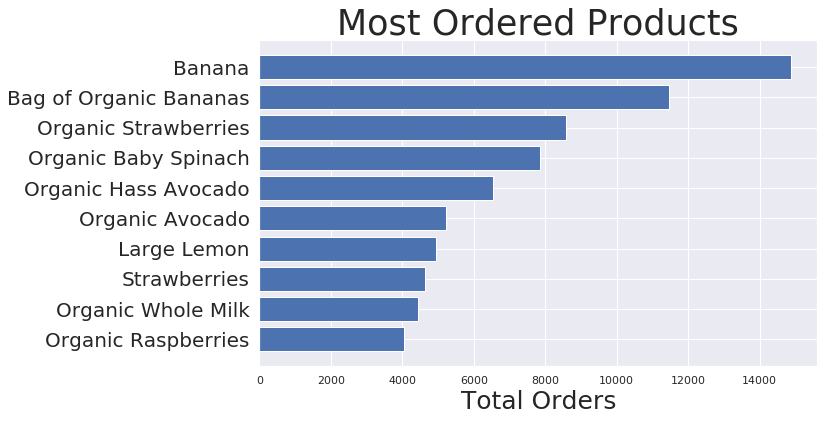

In [18]:
plt.figure(figsize=(10,6))
plt.barh(most_ordered.product_name ,most_ordered.number_of_orders, data=most_ordered)
plt.xlabel('Total Orders', fontsize=25)
plt.ylabel('')
plt.yticks(fontsize=20)
plt.title('Most Ordered Products', fontsize=35)

In [19]:
most_ordered_d = (prior.groupby('department')[['order_id']].count()
                                    .sort_values(('order_id'), ascending=False).reset_index().head(10))
most_ordered_d.columns=['department', 'number_of_orders']
most_ordered_d.sort_values(by='number_of_orders', inplace=True)

Text(0.5, 1.0, 'Most Popular Departments')

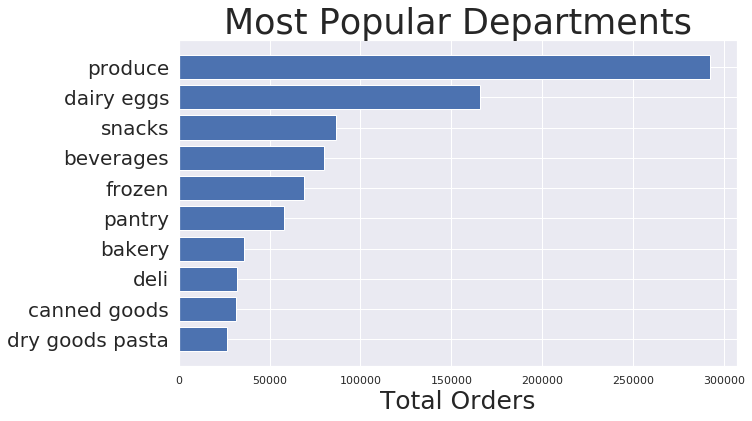

In [20]:
plt.figure(figsize=(10,6))
ax=plt.barh(most_ordered_d.department ,most_ordered_d.number_of_orders)
plt.xlabel('Total Orders', fontsize=25)
plt.ylabel('')
plt.yticks(fontsize=20)
plt.title('Most Popular Departments', fontsize=35)

In [21]:
#avg day since last order
days = (prior.groupby('days_last_order')[['order_id']].count()
                                    .sort_values(('days_last_order'), ascending=False).reset_index())
days.columns=['days_last_order', 'number_of_orders']



(-1, 31)

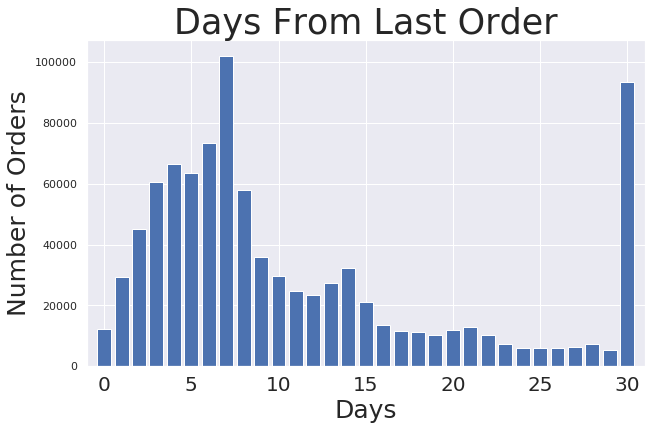

In [22]:
plt.figure(figsize=(10,6))
plt.bar(x=days.days_last_order ,height=days.number_of_orders)
plt.xlabel('Days', fontsize=25)
plt.ylabel('Number of Orders', fontsize=25)
plt.xticks(fontsize=20)
plt.title('Days From Last Order', fontsize=35)
plt.xlim(-1,31)

Text(0.5, 1.0, 'Number of Products per Order')

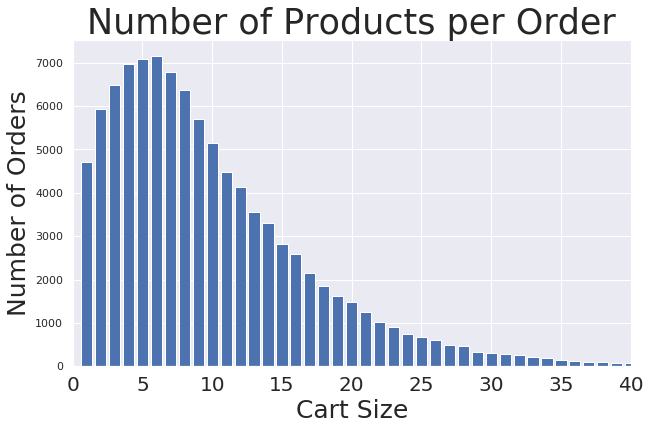

In [23]:
plt.figure(figsize=(10,6))
#cart_size = (prior.groupby('order_id')[['add_cart_order']].max().reset_index())
cart_size = prior.groupby('order_id')[['product_id']].count().reset_index()
a=cart_size.product_id.value_counts().sort_index()
plt.bar(x=a.index, height=a)
plt.xlim(0,40)
plt.xlabel('Cart Size', fontsize=25)
plt.ylabel('Number of Orders', fontsize=25)
plt.xticks(fontsize=20)
plt.title('Number of Products per Order', fontsize=35)

([0, 1], <a list of 2 Text xticklabel objects>)

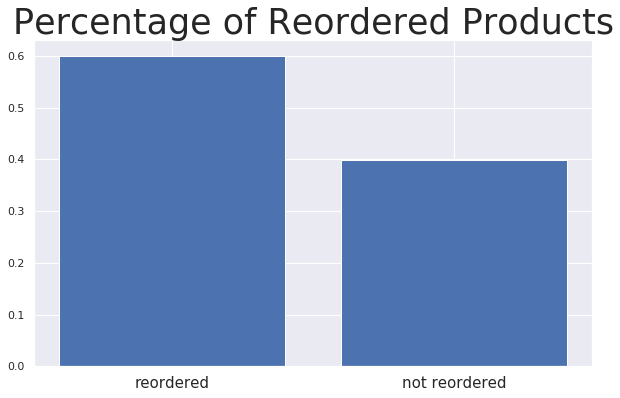

In [24]:
#percentage of reordered products
cart_size = (prior.groupby('order_id')[['reordered']].mean().reset_index())
re=cart_size.reordered.mean()
not_re = 1-re
plt.figure(figsize=(10,6))
plt.bar(['reordered', 'not reordered'], [re, not_re])
plt.title('Percentage of Reordered Products', fontsize=35)
plt.xticks(fontsize=15)

Median number of orders: 9.0


Text(0.5, 1.0, 'Number of Orders per User')

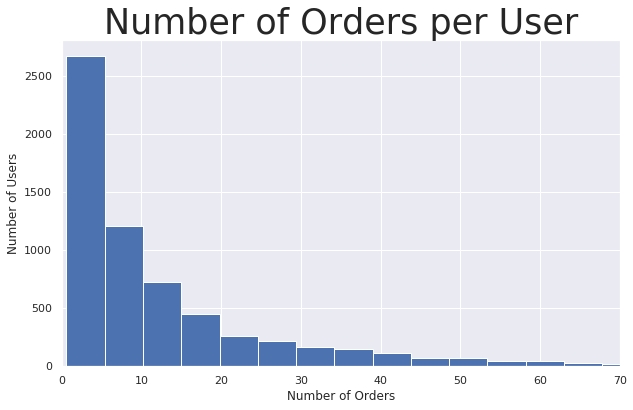

In [25]:
user_number_orders = (prior.groupby('user_id')[['order_id']].nunique().reset_index())
print('Median number of orders:',user_number_orders.order_id.median())
plt.figure(figsize=(10,6))
plt.hist(user_number_orders.order_id, bins=20, align='left')
plt.xlim(0,70)
plt.xlabel('Number of Orders')
plt.ylabel('Number of Users')
plt.title('Number of Orders per User', fontsize=35)

Text(0.5, 1.0, 'Number of Orders per Day')

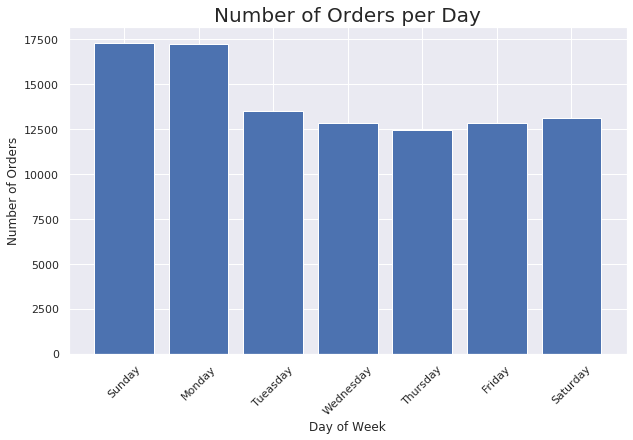

In [26]:
user_order_days = (prior.groupby('order_dow')[['order_id']].nunique().reset_index())
plt.figure(figsize=(10,6))
plt.bar(user_order_days.order_dow,user_order_days.order_id)
plt.xticks(range(7), ['Sunday', 'Monday', 'Tueasday','Wednesday', 'Thursday', 'Friday', 'Saturday'], rotation=45)
plt.xlabel('Day of Week')
plt.ylabel('Number of Orders')
plt.title('Number of Orders per Day', fontsize = 20)


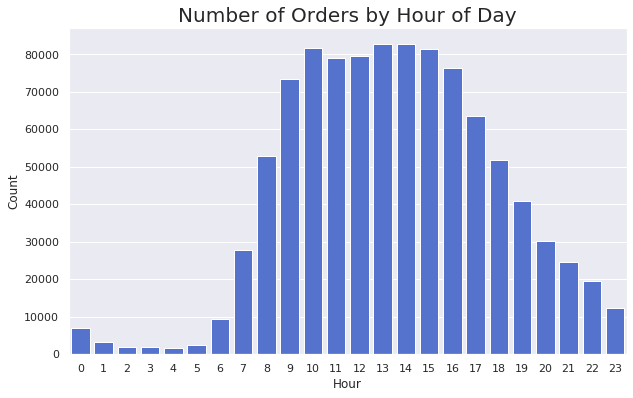

In [27]:
plt.figure(figsize=(10,6))
sns.countplot(prior.order_hour, data=prior, color='royalblue')
plt.title('Number of Orders by Hour of Day',fontsize=20)
plt.xlabel('Hour',fontsize=12)
plt.ylabel('Count',fontsize=12)
plt.show()